# Mini-project n°2 - Conditional VAEs

## I) Contexte du projet et présentation des CVAE

### I.1) Présentation du projet

Au cours de ce projet, nous avons travaillé sur le jeu de données Fashion-MNIST, qui contient des images de vêtements en vente sur Zalando. Les images de vêtements sont séparés dans 10 catégories au sein du jeu de données, selon le type de l'article (T-shirt/top, pantalon, pull-over, robe, manteau, sandales, chemises, baskets, sacs et bottines). Notre objectif est de cosntruire et d'entrainer un réseau de neurone, qui nous permette de générer des images d'un certain type d'article voulu.

### I.2) Présentation des CVAE

Contrairement à ce que nous avons vu en cours et en TP, nous voulons cette fois générer des images d'une certaine catégorie choisie (par exemple une image de pantalon). Cela ne peut pas être réalisé avec un VAE classique, qui va générer une image aléatoirement dans n'importe quelle catégorie. C'est pourquoi nous allons utiliser un VAE Conditionnel (CVAE).  
Un CVAE est une variante du VAE, où l'on renseigne une variable conditionnelle (dans notre cas le type du vêtement) avec les images. Elles vont ainsi être prises en compte au cours de l'entrainement, puis de la génération d'image, ce qui permettra de sélectionner le type d'image à créer.


Plus formellement, ...

## II) Travail préliminaire

### Import des librairies

In [1]:
# Libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import random as rd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import subprocess

def get_gpu_memory():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.free,memory.total', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE)
    memory_info = result.stdout.decode('utf-8').strip()
    return memory_info
gpu_memory = {}
gpu_memory['1. start'] = get_gpu_memory()

### Hyperparamètres

In [3]:
BATCH_SIZE = 128
LATENT_DIM = 10
LEARNING_RATE = 1e-3
EPOCH = 10#5
KL_WEIGHT = 1 

###  Dataset
Le code suivant charge le MNIST dataset et construit les Dataloader d'entrainement et de test.

In [4]:
# Chargement des données
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]



gpu_memory['2. load_dataset'] = get_gpu_memory()

### Observation du dataset

Le dataset contient des images d'articles présents sur le site Zalando. Le jeu d'entrainement contient 60000 articles, et le jeu de test 10000 articles. Chaque image est en niveau de gris (donc sur un seul canal), de taille $28 \times 28$. Le jeu de données d'entrainement est donc de taille $60000\times 28\times 28$.

## III) Définition des VAE

### 1. Define the VAE class
- **The Encoder:** The encoder will consist of the following layers:
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer

- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two parallels fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.

- **The Decoder.** The decoder will consist of the following layers:
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

#### Justificatioon 
Just took the one from the VAE code

In [5]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=1),  # 11 channels: 1 for image + 10 for one-hot labels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) # size : prod(output) , latent_dim 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) # size : prod(output) , latent_dim
        self.fc_decode = nn.Linear(latent_dim + 10, 128 * 4 * 4) # size : latent_dim + numclass, prod(output)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = torch.cat((z, y), dim=1)  # Assurez-vous que y a les dimensions correctes
        z = z.view(z.size(0), -1)  # Verifier z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 4, 4)  # Recréer les dimensions pour passer au décodeur

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x


    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar

#### Model storage
To ensure a great flexibily, all of the code below use a easily incremental dictionnary to add or remove models that you define juste above

In [7]:
# Default initialisation of a model 
def config_model(model, latente_dim = 10, lr = 1e-3): 
    mod = model(latent_dim=latente_dim)
    mod.to(device)
    optimizer_mod = optim.Adam(mod.parameters(), lr=lr)
    return (mod, optimizer_mod)

In [8]:
# A small function that reinit weights for every models in the dict
def reinit(models_dict):
    for _, (model, __) in models_dict.items():
        for layer in model.children():  # runs through the sub-layers of the model.
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()  # Reset settings if possible
    return None

In [9]:
# Dictionnary 
models_dict = {
    'VAE': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'CVAE': config_model(CVAE, LATENT_DIM, LEARNING_RATE),
    '4CVAE': config_model(CVAE, 4, LEARNING_RATE),
    '16CVAE': config_model(CVAE, 16, LEARNING_RATE),
    '32CVAE': config_model(CVAE, 32, LEARNING_RATE),
    '64CVAE': config_model(CVAE, 64, LEARNING_RATE),
    '128CVAE': config_model(CVAE, 128, LEARNING_RATE),
}

gpu_memory['3. model_dict'] = get_gpu_memory()

### 2. Define the loss function

In [10]:
# Loss function that also return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD, BCE, KLD

### 3. Train the VAE

In [11]:
# Training and plotting function
def train(dict_model, train_loader, device, kl_weight=1.0, epochs=30):
    # If it hasn-t been done before, reset the network weights before each training.
    reinit(dict_model)

    # Dictionary to store evolution losses for each model
    evol_losses = {model_name: [] for model_name in dict_model.keys()}
    evol_bce = {model_name: [] for model_name in dict_model.keys()}
    evol_kl = {model_name: [] for model_name in dict_model.keys()}

    # Training phase over epochs
    for epoch in range(1, epochs + 1):

        # Variables to accumulate losses during the period
        running_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        bce_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        kld_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        
        for (data, labels) in train_loader:
            # Move data and labels to the GPU (if available)
            data = data.to(device) 
            labels = torch.eye(10)[labels].to(device)  # One-hot encoding des labels

            # Loop for each model in the dictionary
            for model_name, (model, optimizer) in dict_model.items():
                model.train()
                optimizer.zero_grad()  

                # Models are differentiated according to whether they take labels into account
                if model_name == "VAE":
                    recon_batch, mu, logvar = model(data)  # VAE only takes 'data'
                else:
                    recon_batch, mu, logvar = model(data, labels)  # Others take the labels too
                
                loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)                

                loss.backward()
                optimizer.step()

                running_losses[model_name] += loss.item()
                bce_losses[model_name] += bce.item()
                kld_losses[model_name] += kld.item()

        # Calculate average losses for each model at the end of the period
        for model_name in dict_model.keys():
            epoch_loss = running_losses[model_name] / len(train_loader.dataset)
            epoch_bce = bce_losses[model_name] / len(train_loader.dataset)
            epoch_kld = kld_losses[model_name] / len(train_loader.dataset)

            evol_losses[model_name].append(epoch_loss)
            evol_bce[model_name].append(epoch_bce)
            evol_kl[model_name].append(epoch_kld)

            # Display during training
            print(f'Epoch {epoch}: Model {model_name} - Loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Storage of losses that can be reused later (display)
    loss_dict = {
        'evol_losses': evol_losses,
        'evol_bce': evol_bce,
        'evol_kl': evol_kl
    }
    return loss_dict

"""
# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight=1.0, dict_model=models_dict, train_loader=train_loader, device=device, epochs=num_epochs)


"""

"\n# Run training and plotting for different KL weights\nfor kl_weight in kl_weights:\n    print(f'\nTraining VAE with KL Weight = {kl_weight}')\n    train_and_plot(kl_weight=1.0, dict_model=models_dict, train_loader=train_loader, device=device, epochs=num_epochs)\n\n\n"

In [12]:
loss_dict = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

gpu_memory['4. model trained'] = get_gpu_memory()

Epoch 1: Model VAE - Loss: 267.3058, BCE: 252.8022, KLD: 14.5036
Epoch 1: Model CVAE - Loss: 262.5839, BCE: 250.5814, KLD: 12.0025
Epoch 1: Model 4CVAE - Loss: 264.5836, BCE: 256.8854, KLD: 7.6981
Epoch 1: Model 16CVAE - Loss: 267.0234, BCE: 253.7541, KLD: 13.2694
Epoch 1: Model 32CVAE - Loss: 270.6124, BCE: 256.5642, KLD: 14.0482
Epoch 1: Model 64CVAE - Loss: 272.4190, BCE: 258.0320, KLD: 14.3870
Epoch 1: Model 128CVAE - Loss: 279.0653, BCE: 263.8125, KLD: 15.2528
Epoch 2: Model VAE - Loss: 246.8425, BCE: 231.6547, KLD: 15.1878
Epoch 2: Model CVAE - Loss: 243.5848, BCE: 231.1827, KLD: 12.4021
Epoch 2: Model 4CVAE - Loss: 247.3716, BCE: 239.6810, KLD: 7.6906
Epoch 2: Model 16CVAE - Loss: 244.3123, BCE: 230.9856, KLD: 13.3267
Epoch 2: Model 32CVAE - Loss: 245.7323, BCE: 232.1932, KLD: 13.5392
Epoch 2: Model 64CVAE - Loss: 247.2643, BCE: 233.7558, KLD: 13.5085
Epoch 2: Model 128CVAE - Loss: 248.9198, BCE: 235.4231, KLD: 13.4967
Epoch 3: Model VAE - Loss: 244.3985, BCE: 229.1583, KLD: 15.

### 4. Plot loss evolution
Here we plot the loss fucntions for each models to seek for differences


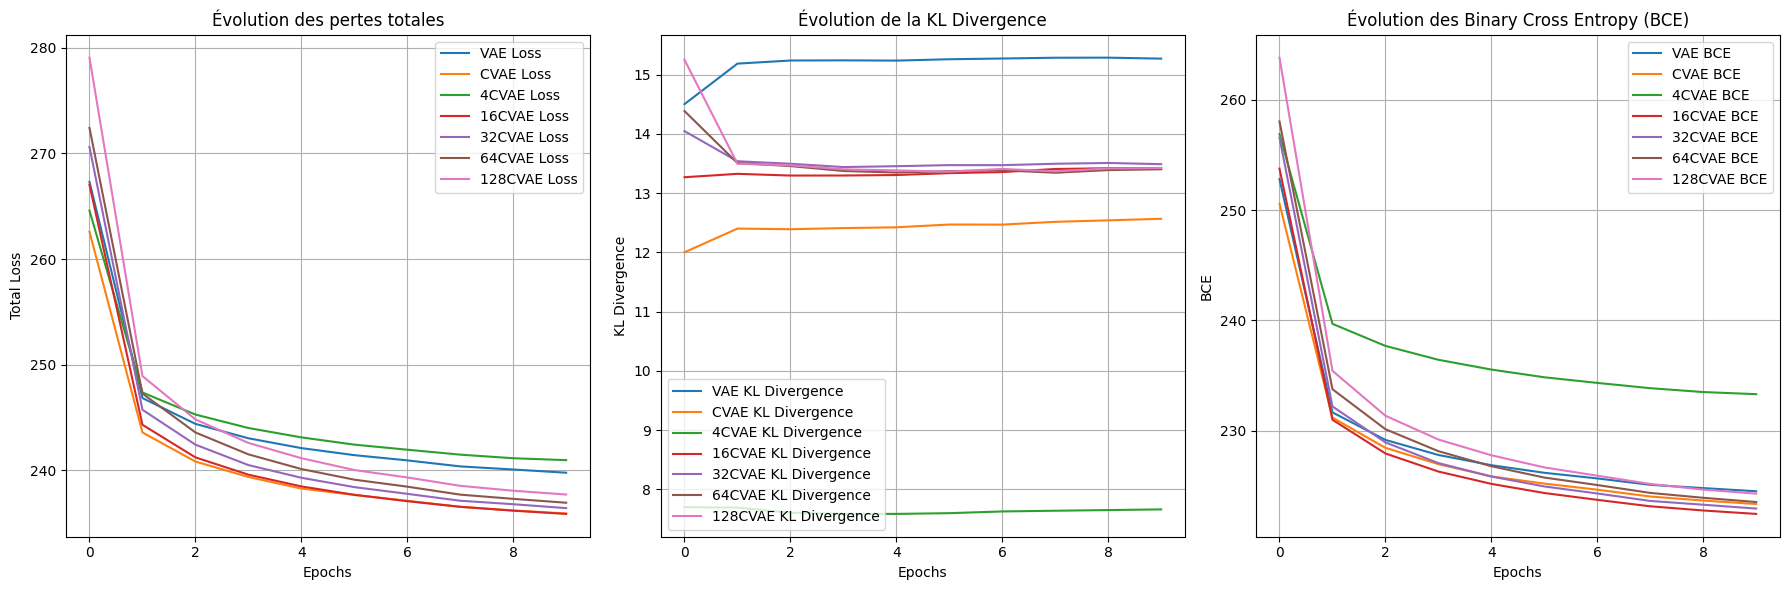

In [13]:
def plot_losses(evol_losses, evol_bce, evol_kl):
    plt.figure(figsize=(18, 6))

    # Graph 1 : Total loss
    plt.subplot(1, 3, 1)
    for model_name, losses in evol_losses.items():
        plt.plot(losses, label=f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')
    plt.title('Évolution des pertes totales')
    plt.legend()
    plt.grid(True)

    # Graph 2 : KL Divergence
    plt.subplot(1, 3, 2)
    for model_name, kl_losses in evol_kl.items():
        plt.plot(kl_losses, label=f'{model_name} KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('Évolution de la KL Divergence')
    plt.legend()
    plt.grid(True)

    # Graph 3 : Binary Cross Entropy (BCE)
    plt.subplot(1, 3, 3)
    for model_name, bce_losses in evol_bce.items():
        plt.plot(bce_losses, label=f'{model_name} BCE')
    plt.xlabel('Epochs')
    plt.ylabel('BCE')
    plt.title('Évolution des Binary Cross Entropy (BCE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl'])

In [14]:
def image_comparison(original_images, dict_recons, n_images=6):
    """Plots the original images and their reconstructions for comparison

    Args:
        original_images (torch.Tensor): The original images
        dict_recons (dict): Dictionary with reconstruction labels as keys and images as values
        n_images (int): Number of images to display
    """

    # Créer une figure avec un nombre de lignes correspondant aux reconstructions + 1 pour les images originales
    fig, ax = plt.subplots(len(dict_recons) + 1, n_images, figsize=(20, 7))

    # Affichage des images originales
    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

    # Affichage des reconstructions
    for row, (key, value) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            ax[row, i].imshow(value[i], cmap='gray')
            ax[row, i].axis('off')
            ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

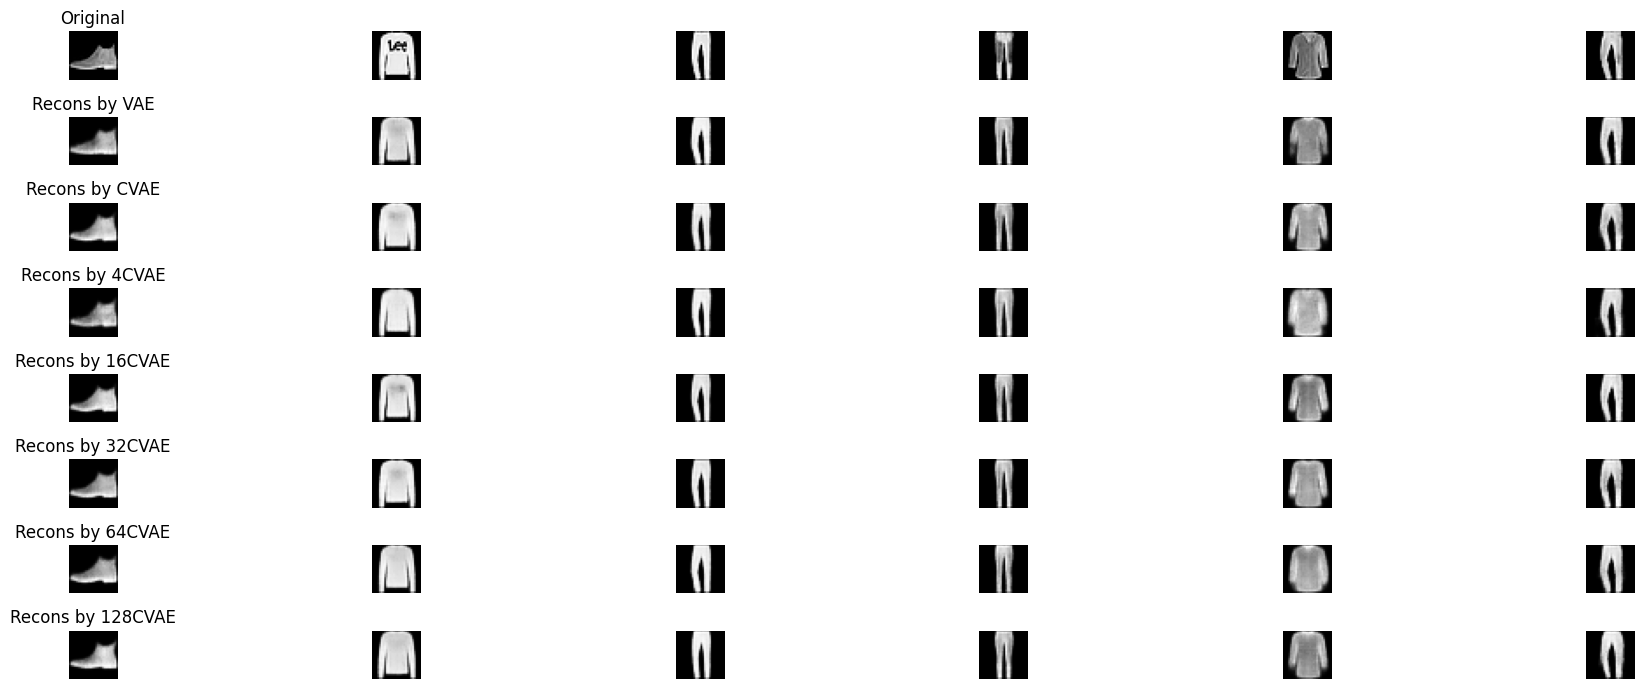

In [15]:
# Function for obtaining and comparing image reconstructions

def compare_model_reconstructions(models_dict, test_loader, device):

    random_images, random_labels = next(iter(test_loader))

    random_labels_one_hot = torch.eye(10)[random_labels].to(device) #One hot encoding

    random_images = random_images.to(device)
    
    # Dictionary for storing model reconstructions
    dict_recons = {}


    for model_name, (model, _) in models_dict.items():
        model.eval()

        with torch.no_grad():
            if "VAE" == model_name: 
                recons, _, _ = model(random_images)
            else:  # Pour les modèles comme VAE, pas besoin des labels
                recons, _, _ = model(random_images, random_labels_one_hot)
            
            # Prepare reconstructions for display
            recons = recons.detach().cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]
            dict_recons[f"Recons by {model_name}"] = recons

    # Préparer les images originales pour l'affichage
    random_images = random_images.cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]

    # Display original images and their reconstructions
    image_comparison(random_images, dict_recons)


# Comparison of model reconstructions
compare_model_reconstructions(models_dict, test_loader, device)



### 5. Image generation
The puropose of this section is to generate new images that look like MNIST digits for every trained models. In order to do so, we follow the steps below:
- Sample $z$ from a $\mathcal{N}(0, I)$ distribution ($I$ being the identity matrix of size $p$).
- Decode $z$ using the decoder of the VAE to generate a new image.
- Add the contionning if necessary


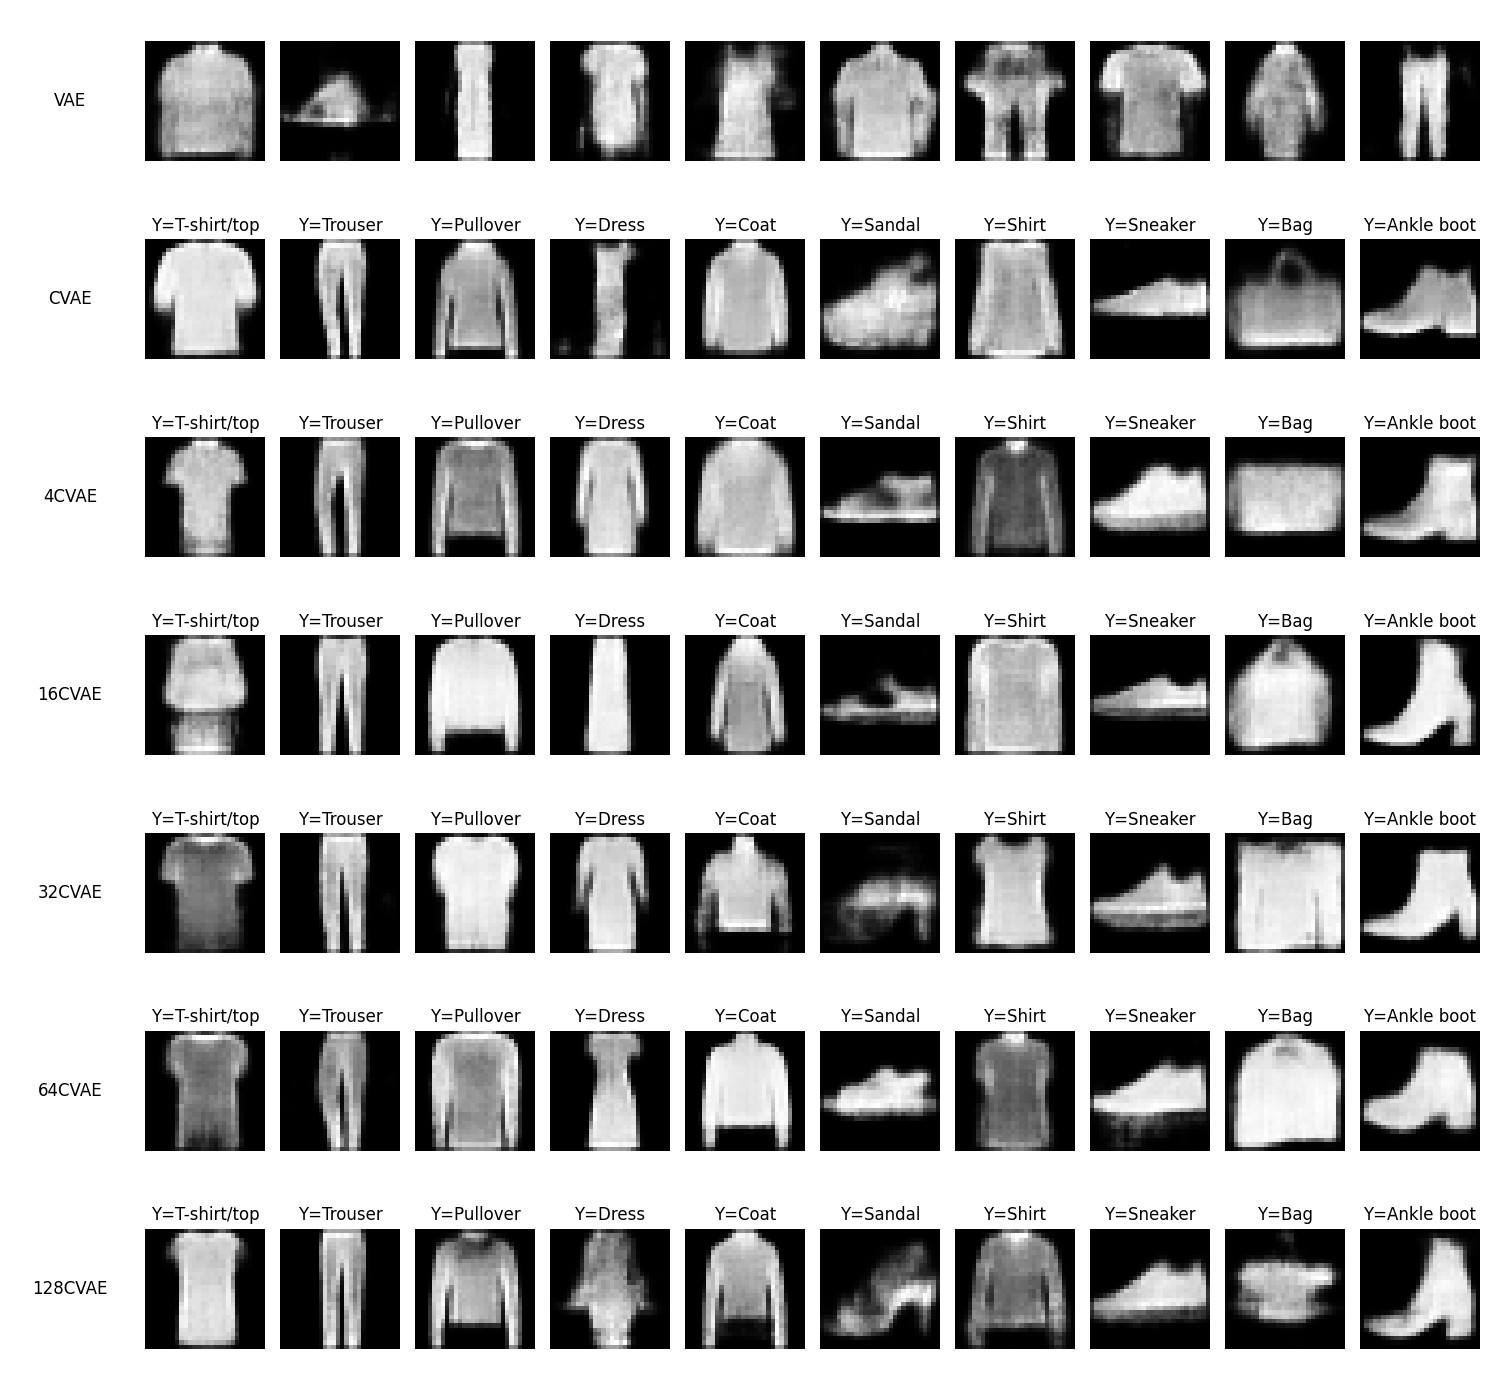

In [16]:
def generate_samples_plot(models_dict, num_samples=10):
    # Set all models to evaluation mode
    for model_name, (model, _) in models_dict.items():  # Extract only the model
        model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        y = torch.eye(10)[:num_samples].to(device)
        
        num_models = len(models_dict)
        
        # Create figure with dynamic subplots: (num_models rows, num_samples + 1 columns)
        fig, ax = plt.subplots(num_models, num_samples + 1, figsize=(15, 2 * num_models))
        
        # Loop over the models to generate samples
        for i, (model_name, (model, _)) in enumerate(models_dict.items()):
            z = torch.randn(num_samples, model.latent_dim).to(device)  # Random latent vectors
            # Use decode method depending on whether it's a VAE or CVAE
            if "VAE" == model_name:  
                samples = model.decode(z)  # VAE doesn't use labels
            else:
                samples = model.decode(z, y)  # CVAE uses labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples
            
            # Display model name in the first column (extra column added for the name)
            ax[i, 0].text(0.5, 0.5, f'{model_name}', horizontalalignment='center', 
                          verticalalignment='center', fontsize=12, transform=ax[i, 0].transAxes)
            ax[i, 0].axis('off')  # Turn off axis for the model name column
            
            # Display samples for this model
            for j in range(1, num_samples + 1):  # Start at 1 to account for the extra column
                ax[i, j].imshow(samples[j-1].squeeze(0), cmap='gray')  # Adjust index for samples
                ax[i, j].axis('off')
                if "CVAE" in model_name: 
                    ax[i, j].set_title(f'Y={class_names[j-1]}')  # Display the labels for which use labels

        plt.tight_layout()
        plt.show()




# Call function
generate_samples_plot(models_dict=models_dict)


In [17]:
def generate_random_matrix(n, m):
    # Créer un tensor de zéros de dimension n x m
    matrix = torch.zeros((n, m), dtype=torch.int)

    # Générer des indices de colonnes aléatoires pour chaque ligne
    col_indices = torch.randint(0, m, (n,))

    # Utiliser l'indexation avancée pour placer un 1 dans chaque ligne
    matrix[torch.arange(n), col_indices] = 1  # Pourquoi pas juste un : ?

    return matrix





# Pourquoi pas repasser à models_dictionary en entrée par la suite
# catégory -1 --> aléatoire

def generate_samples(model, num_samples=10, type_model = 'CVAE', category=-1):
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        if category == -1:
            y = generate_random_matrix(num_samples, 10).to(device)
        else:
            # peut-être faire une petite fonction pour cette partie
            y = torch.zeros((num_samples, 10), dtype=torch.int).to(device)
            y[:, category] = 1
        
        z = torch.randn(num_samples, model.latent_dim).to(device)  # Random latent vectors
            # Use decode method depending on whether it's a VAE or CVAE
        if "VAE" == type_model:  
            samples = model.decode(z)  # VAE doesn't use labels
        else:
            samples = model.decode(z, y)  # CVAE uses labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples
            
        return samples, y



(model, _) = models_dict['CVAE']
# Call function
samples_cvae, labels_cvae = generate_samples(model = model, num_samples = 10000)

(model, _) = models_dict['4CVAE']
# Call function
samples_4cvae, labels_4cvae = generate_samples(model = model, num_samples = 10000)

(model, _) = models_dict['16CVAE']
# Call function
samples_16cvae, labels_16cvae = generate_samples(model = model, num_samples = 10000)

(model, _) = models_dict['32CVAE']
# Call function
samples_32cvae, labels_32cvae = generate_samples(model = model, num_samples = 10000)

(model, _) = models_dict['64CVAE']
# Call function
samples_64cvae, labels_64cvae = generate_samples(model = model, num_samples = 10000)

(model, _) = models_dict['128CVAE']
# Call function
samples_128cvae, labels_128cvae = generate_samples(model = model, num_samples = 10000)

gpu_memory['5. images generated'] = get_gpu_memory()

torch.Size([10000, 1, 28, 28])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)


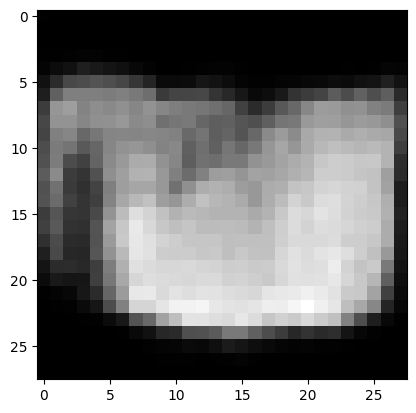

In [18]:
print(samples_cvae.size())
print(labels_cvae[3525])
plt.imshow(samples_cvae[3525].squeeze(0), cmap='gray')

## IV) Analyse des résultats et optimisation des paramètres

### 1. Latent Spaces
Here we are comparing latents space to seek for differences 

In order to be able to visualize the latent space of the VAE, we retrain the model and will choose a latent dimension equal to 2.

In [19]:
# Function to plot latent space
def plot_latent_space(models_dict, test_dataset, device, kl_weight=1.0) :
    # Fig initialisation
    plt.figure(figsize=(16, 6))
    
    for i, (model_name, (model, _)) in enumerate(models_dict.items(), 1):

        model.eval()
        with torch.no_grad():

            test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
            data, labels = next(iter(test_loader))
            data = data.to(device)
            labels = labels.to(device)

            # Adjust label size to match data batch_size
            if labels.size(0) != data.size(0):
                raise RuntimeError(f"Les tailles des données ({data.size(0)}) et des labels ({labels.size(0)}) ne correspondent pas.")
                

            # Manage labels to match data (One-hot encoding already supported)
            if labels.dim() == 1:  # If labels are in integer form (not encoded)
                labels = torch.eye(10).to(device)[labels].to(device)  # One-hot encodes if necessary

            if model_name == "VAE":
                mu, _ = model.encode(data)
            else:
                mu, _ = model.encode(data, labels)

            z = mu  
            z = z.cpu().numpy()
            labels = labels.cpu().numpy()

            # Sub-graph for each model
            plt.subplot(1, 2, i)
            scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.argmax(axis=1), cmap='tab10', alpha=0.7)  # Utilise les labels comme catégories
            plt.colorbar(scatter, ticks=range(10))
            plt.clim(-0.5, 9.5)
            plt.title(f'{model_name} Latent Space with KL Weight = {kl_weight}')
            plt.xlabel('Z1')
            plt.ylabel('Z2')

    plt.tight_layout()
    plt.show()

In [20]:
models_dict = {
    'VAE': config_model(ConvVAE, latente_dim=2,lr = LEARNING_RATE),
    'CVAE': config_model(CVAE, latente_dim=2, lr = LEARNING_RATE)
}

In [21]:
_ = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs= EPOCH)

gpu_memory['6. classifier trained'] = get_gpu_memory()

Epoch 1: Model VAE - Loss: 285.0937, BCE: 279.5861, KLD: 5.5076
Epoch 1: Model CVAE - Loss: 277.1446, BCE: 272.3622, KLD: 4.7824
Epoch 2: Model VAE - Loss: 269.7555, BCE: 263.8585, KLD: 5.8971
Epoch 2: Model CVAE - Loss: 256.7443, BCE: 252.0843, KLD: 4.6600
Epoch 3: Model VAE - Loss: 267.0729, BCE: 261.1166, KLD: 5.9563
Epoch 3: Model CVAE - Loss: 255.0106, BCE: 250.3922, KLD: 4.6184
Epoch 4: Model VAE - Loss: 265.5148, BCE: 259.5202, KLD: 5.9946
Epoch 4: Model CVAE - Loss: 254.1649, BCE: 249.5813, KLD: 4.5836
Epoch 5: Model VAE - Loss: 264.5068, BCE: 258.4892, KLD: 6.0176
Epoch 5: Model CVAE - Loss: 253.3873, BCE: 248.8453, KLD: 4.5420
Epoch 6: Model VAE - Loss: 263.7496, BCE: 257.7040, KLD: 6.0456
Epoch 6: Model CVAE - Loss: 252.9671, BCE: 248.4251, KLD: 4.5420
Epoch 7: Model VAE - Loss: 263.1486, BCE: 257.0796, KLD: 6.0689
Epoch 7: Model CVAE - Loss: 252.5439, BCE: 247.9949, KLD: 4.5490
Epoch 8: Model VAE - Loss: 262.5057, BCE: 256.4397, KLD: 6.0660
Epoch 8: Model CVAE - Loss: 252.2

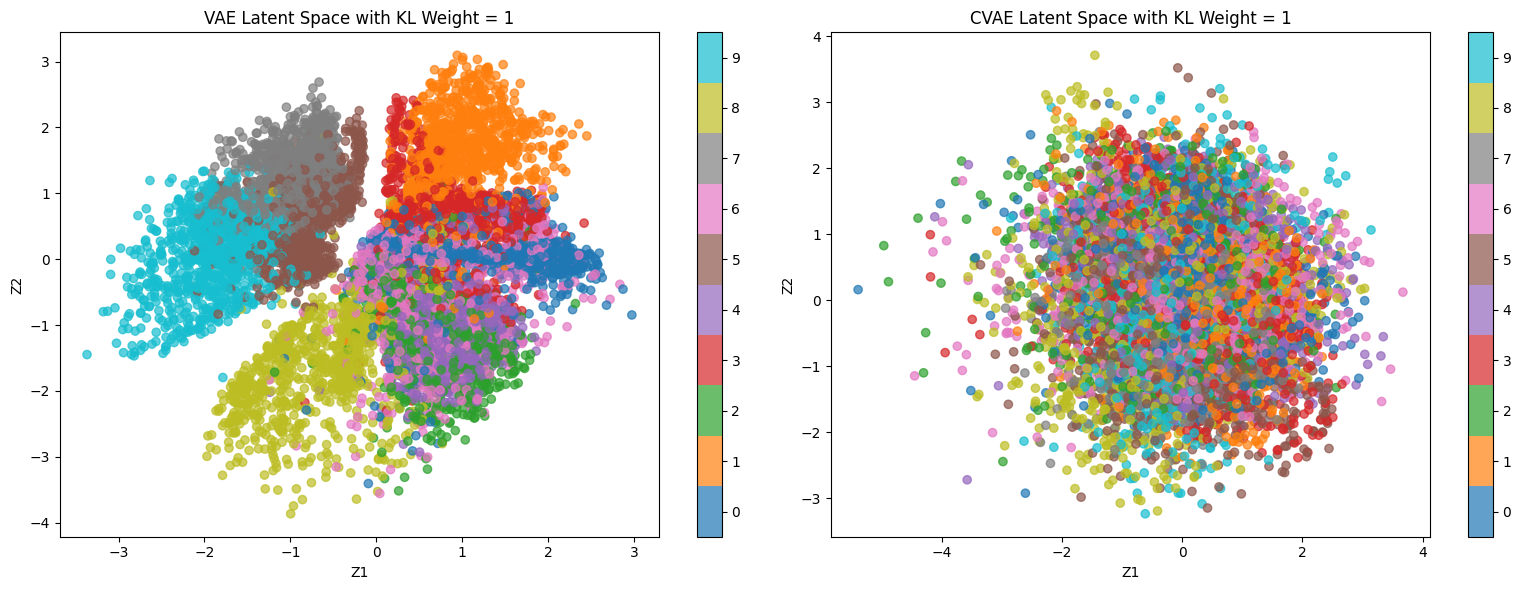

In [22]:
plot_latent_space(models_dict=models_dict, test_dataset= test_dataset, device =device,  kl_weight=KL_WEIGHT)

### 2. Evaluation of the generation

Comparer les performances de plusieurs modèles nécessite de comparer leurs résultats. Cela est particulièrement compliqué pour les modèles génératifs. En effet, l'objectif du modèle est de créer des images originales et, en même temps réaliste, on ne peut donc pas l'évaluer en comparant les contenus générés avec le jeu de test par exemple.

Cependant, il existe des méthodes spécifiques pour évaluer les performances des modèles génératifs. En particulier, il existe des méthodes telles que l'Inception Score (IS) et la Fréchet Inception Distance (FID) pour mesurer la qualité des images créés avec les images réelles. Il existe également des méthodes basées sur l'originalité des images générées, comme le Nearest Neighbor Distance

Liens généraux :
https://dagshub.com/blog/how-to-evaluate-generative-image-models/
https://sh-tsang.medium.com/brief-review-stylegan-a-style-based-generator-architecture-for-generative-adversarial-networks-5051d79aad53
https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/
https://arxiv.org/pdf/1802.03446     Extrêmement complet



Liens Inception score :
https://en.wikipedia.org/wiki/Inception_score -> Classification des images générées, évalue la distribution des images générées

Lien FID :
https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance
-> Comparaison de la diversité des images générées avec le jeu réel

CLIP ? https://en.wikipedia.org/wiki/Contrastive_Language-Image_Pre-training

Perceptual Path Language ? https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Build%20Better%20Generative%20Adversarial%20Networks%20(GANs)/Week%201%20-%20Evaluation%20of%20GANs/PPL.ipynb



Test humain :
Turing Test https://www.nature.com/articles/s41598-023-45290-1


#### 1ere méthode : classification par un CNN entrainé sur le jeu de données réal

Je vais entrainer un CNN à reconnaitre les images réelles, et observer si il est aussi performant sur les images générées

In [23]:
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassificationCNN, self).__init__()
        
        # Bloc convolutionnel 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc convolutionnel 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc convolutionnel 3
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Couches entièrement connectées
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Ajuster la taille selon la taille d'entrée
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Aplatir les features maps pour les couches entièrement connectées
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Exemple d'initialisation du modèle
model = ClassificationCNN(num_classes=10)
print(model)

ClassificationCNN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): 

In [24]:
model_classCNN = ClassificationCNN(num_classes=10)  # Adapter `num_classes` selon le dataset
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model_classCNN.parameters(), lr=0.001)  # Optimiseur Adam avec un learning rate de 0.001

In [25]:
model_classCNN.to(device)

num_epochs = 10  # Nombre d'époques pour l'entraînement

for epoch in range(num_epochs):
    model_classCNN.train()  # Mode entraînement
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):  # Assurez-vous d'avoir un DataLoader `train_loader`
        # Déplacer les données vers le bon appareil
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Remise à zéro des gradients
        optimizer.zero_grad()
        
        # Passage avant + backward + optimisation
        outputs = model_classCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids
        
        # Affichage de la perte cumulée
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Afficher tous les 100 lots
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print("Entraînement terminé")


Epoch [1/10], Step [100/469], Loss: 0.6717
Epoch [1/10], Step [200/469], Loss: 0.3999
Epoch [1/10], Step [300/469], Loss: 0.3659
Epoch [1/10], Step [400/469], Loss: 0.3021
Epoch [2/10], Step [100/469], Loss: 0.2572
Epoch [2/10], Step [200/469], Loss: 0.2494
Epoch [2/10], Step [300/469], Loss: 0.2441
Epoch [2/10], Step [400/469], Loss: 0.2412
Epoch [3/10], Step [100/469], Loss: 0.2143
Epoch [3/10], Step [200/469], Loss: 0.2152
Epoch [3/10], Step [300/469], Loss: 0.2085
Epoch [3/10], Step [400/469], Loss: 0.2033
Epoch [4/10], Step [100/469], Loss: 0.1707
Epoch [4/10], Step [200/469], Loss: 0.1792
Epoch [4/10], Step [300/469], Loss: 0.1780
Epoch [4/10], Step [400/469], Loss: 0.1860
Epoch [5/10], Step [100/469], Loss: 0.1468
Epoch [5/10], Step [200/469], Loss: 0.1615
Epoch [5/10], Step [300/469], Loss: 0.1547
Epoch [5/10], Step [400/469], Loss: 0.1524
Epoch [6/10], Step [100/469], Loss: 0.1168
Epoch [6/10], Step [200/469], Loss: 0.1422
Epoch [6/10], Step [300/469], Loss: 0.1316
Epoch [6/10

In [26]:
model_classCNN.eval()

def eval_classif_loader(test_loader):
    # Variables pour stocker les résultats
    correct = 0
    total = 0

    # Désactiver le calcul des gradients pour l'évaluation (économise de la mémoire)
    with torch.no_grad():
        for inputs, labels in test_loader:  # Assurez-vous d'avoir un DataLoader `test_loader`
            # Déplacer les données vers l'appareil utilisé (CPU ou GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Récupérer la classe avec la plus grande probabilité
            
            # Compter le nombre de prédictions correctes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total # Calcul de l'accuracy
    return accuracy


def eval_classif_tensor(samples, labels):
    # Variables pour stocker les résultats
    correct = 0
    total = 0

    # Désactiver le calcul des gradients pour l'évaluation (économise de la mémoire)
    with torch.no_grad():
        for i in range(int(samples.size()[0]/10)):  # Assurez-vous d'avoir un DataLoader `test_loader`
            # Déplacer les données vers l'appareil utilisé (CPU ou GPU)
            inputs, labels_temp = samples[i*10:i*10+10].to(device), torch.argmax(labels[i*10:i*10+10], dim=1).to(device)

            # Prédictions du modèle
            outputs = model_classCNN(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Récupérer la classe avec la plus grande probabilité
            
            # Compter le nombre de prédictions correctes
            total += labels_temp.size(0)
            correct += (predicted == labels_temp).sum().item()

    accuracy = 100 * correct / total # Calcul de l'accuracy
    return accuracy



In [27]:
accuracy_test = eval_classif_loader(test_loader)
print(f'Accuracy on the test set: {accuracy_test:.2f}%')

Accuracy on the test set: 93.24%


On va maintenant faire de même sur des images générées par nos réseaux.

In [28]:
# CVAE
accuracy_cvae = eval_classif_tensor(samples_cvae, labels_cvae)
print(f'Accuracy on 10CVAE: {accuracy_cvae:.2f}%')

# 4CVAE
accuracy_4cvae = eval_classif_tensor(samples_4cvae, labels_4cvae)
print(f'Accuracy on 4CVAE: {accuracy_4cvae:.2f}%')

# 16CVAE
accuracy_16cvae = eval_classif_tensor(samples_16cvae, labels_16cvae)
print(f'Accuracy on 16CVAE: {accuracy_16cvae:.2f}%')

# 32CVAE
accuracy_32cvae = eval_classif_tensor(samples_32cvae, labels_32cvae)
print(f'Accuracy on 32CVAE: {accuracy_32cvae:.2f}%')

# 64CVAE
accuracy_64cvae = eval_classif_tensor(samples_64cvae, labels_64cvae)
print(f'Accuracy on 64CVAE: {accuracy_64cvae:.2f}%')

# 128CVAE
accuracy_128cvae = eval_classif_tensor(samples_128cvae, labels_128cvae)
print(f'Accuracy on 128CVAE: {accuracy_128cvae:.2f}%')

Accuracy on 10CVAE: 80.64%
Accuracy on 4CVAE: 81.44%
Accuracy on 16CVAE: 82.44%
Accuracy on 32CVAE: 81.26%
Accuracy on 64CVAE: 79.73%
Accuracy on 128CVAE: 78.53%


In [ ]:
# 5 époques :

'''Accuracy on 10CVAE: 79.28%
Accuracy on 4CVAE: 79.99%
Accuracy on 16CVAE: 79.15%
Accuracy on 32CVAE: 79.30%
Accuracy on 64CVAE: 77.87%
Accuracy on 128CVAE: 77.18%'''

'''Accuracy on 10CVAE: 78.24%
Accuracy on 4CVAE: 78.03%
Accuracy on 16CVAE: 78.40%
Accuracy on 32CVAE: 76.77%
Accuracy on 64CVAE: 76.78%
Accuracy on 128CVAE: 73.95%'''

'''Accuracy on 10CVAE: 81.80%
Accuracy on 4CVAE: 85.06%
Accuracy on 16CVAE: 82.42%
Accuracy on 32CVAE: 80.28%
Accuracy on 64CVAE: 78.55%
Accuracy on 128CVAE: 77.23%'''

# 10 époques :

'''Accuracy on 10CVAE: 82.84%
Accuracy on 4CVAE: 84.25%
Accuracy on 16CVAE: 84.31%
Accuracy on 32CVAE: 84.74%
Accuracy on 64CVAE: 82.51%
Accuracy on 128CVAE: 80.68%'''

'''Accuracy on 10CVAE: 83.33%
Accuracy on 4CVAE: 83.00%
Accuracy on 16CVAE: 82.83%
Accuracy on 32CVAE: 82.97%
Accuracy on 64CVAE: 79.44%
Accuracy on 128CVAE: 79.18%'''

'''Accuracy on 10CVAE: 83.59%
Accuracy on 4CVAE: 85.48%
Accuracy on 16CVAE: 82.45%
Accuracy on 32CVAE: 81.01%
Accuracy on 64CVAE: 80.46%
Accuracy on 128CVAE: 78.14%'''

'''Accuracy on 10CVAE: 80.38%
Accuracy on 4CVAE: 81.06%
Accuracy on 16CVAE: 80.07%
Accuracy on 32CVAE: 80.32%
Accuracy on 64CVAE: 77.93%
Accuracy on 128CVAE: 76.88%'''

'''Accuracy on 10CVAE: 80.64%
Accuracy on 4CVAE: 81.44%
Accuracy on 16CVAE: 82.44%
Accuracy on 32CVAE: 81.26%
Accuracy on 64CVAE: 79.73%
Accuracy on 128CVAE: 78.53%'''




# A tester plusieurs fois car les valeurs changent à chaque fois
# Généraliser le code
# Essayer d'observer où sont les erreurs

'Accuracy on 10CVAE: 80.38%\nAccuracy on 4CVAE: 81.06%\nAccuracy on 16CVAE: 80.07%\nAccuracy on 32CVAE: 80.32%\nAccuracy on 64CVAE: 77.93%\nAccuracy on 128CVAE: 76.88%'

Les résultats sont variables : plusieurs exécutions et on fait la moyenne/boxplot

#### 2eme méthode : test de Turing (test manuel)

Le principe du test de Turing est simple : on va présenter à un humain des images, certaines faisant parties de la base de donénes MINST, et certaines générées par le CNN. Le testeur doit alors retrouver quelles images ont étés générées et lesquelles sont des images réelles. 

Comme je pense que les résultats avec ce test vont être assez mauvais, et ne permettront pas forcément de distinguer des petties différences de résultats sans utiliser un grand nombre d'image, je vais plutôt garder ce test pour les meilleures méthodes.

In [30]:
# On va tirer pour chaque catégorie 5 images par catégorie dans le jeu de données MNIST
def get_random_images_per_category(dataset, num_images=5):
    # Création d'une liste pour stocker les images par catégorie
    categories = {i: [] for i in range(10)}  # Il y a 10 catégories (0-9)

    # Boucle pour remplir les catégories
    for image, label in dataset:
        # Ajouter l'image à la catégorie correspondante
        if len(categories[label]) < num_images:
            categories[label].append(image)

        # Arrêter la collecte si toutes les catégories ont le nombre requis d'images
        if all(len(categories[i]) == num_images for i in range(10)):
            break

    return categories


def add_generated_images(true_images, model, num_images=5):
    indice_images = np.zeros((10,num_images*2))  # On construit une matrice pour retenir quelles images sont les vraies, 10 correspond au nombre de catégories
    # 1 correspond à une image générée
    for i in range(10): # On parcourt les catégories
        samples = generate_samples(model, num_samples=num_images, type_model = 'CVAE', category = i)[0]
        # On ajoute les images générées aux images de base
        for j in range(num_images):
            true_images[i].append(samples[j])
        # On fait un shuffle sur la liste
        indice_alea = list(range(num_images*2))
        rd.shuffle(indice_alea)
        true_images[i] = np.array(true_images[i])[indice_alea]
        indice_generated = np.where(np.array(indice_alea) > 4.5)[0] # On récupère les indices qui correspondent aux images générées
        indice_images[i,indice_generated] = 1

    return true_images, indice_images

    
        
def test_Turing(images, indices):

    score = 0

    for i in range(10):  # On parcourt les catégories
        for j, image in enumerate(images[i]):
            plt.imshow(image.squeeze(), cmap="gray")
            plt.title(f"Image de {i} : {class_names[i]}")
            plt.show()
            print("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non")
            temp = "2"
            while temp !="1" and temp != "0":
                temp = input("Cette image est-elle générée par IA ? 1 pour oui, 0 pour non:")
            if int(temp) == indices[i,j]:
                score += 1
    return score




(model, _) = models_dict['CVAE']

random_images = get_random_images_per_category(train_dataset)
images, indices = add_generated_images (random_images, model)
#score = test_Turing(images, indices)
#print(score)


#category = 5
#plt.imshow(random_images[category][4].squeeze(), cmap="gray")
#plt.title(f"Exemple de catégorie {category} : {class_names[category]}")
#plt.show()





#### 3eme méthode : FID (Fréchet inception distance)

Problème de mémoire dans le gpu à régler (batch sur les images générées, mettre moins d'images, changement de la structure du code)

In [35]:
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm


gpu_memory['7. before Fréchet'] = get_gpu_memory()



# Initialiser la métrique
fid = FrechetInceptionDistance(feature=2048).to("cuda")

# Ajouter les features pour les images réelles et générées
for (real_images, _) in tqdm(test_loader, desc="Processing Batches", total=len(test_loader)):
    real_images = (real_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
    real_images = real_images.repeat(1, 3, 1, 1).to("cuda")
    fid.update(real_images, real=True)
    #fid.update(torch.stack(real_images), real=True)  # Images réelles

gpu_memory['8. Fréchet im origin'] = get_gpu_memory()
print(gpu_memory)

gen_images = samples_cvae [:500]
gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
gen_images = gen_images.repeat(1, 3, 1, 1).to("cuda")
print(gen_images.size())
fid.update(gen_images, real=False)  # Images générées

gpu_memory['9. Fréchet +200 généré'] = get_gpu_memory()
print(gpu_memory)

# Calculer la FID
score = fid.compute()
print(f"FID Score 10: {score}")


'''
gen_images = samples_cvae[:200]
gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
gen_images = gen_images.repeat(1, 3, 1, 1).to("cuda")
print(gen_images.size())
fid.update(gen_images, real=False)  # Images générées

# Calculer la FID
score = fid.compute()
print(f"FID Score 10: {score}")




gen_images = samples_cvae[:200]
gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
gen_images = gen_images.repeat(1, 3, 1, 1).to("cuda")
print(gen_images.size())
fid.update(gen_images, real=False)  # Images générées

# Calculer la FID
score = fid.compute()
print(f"FID Score 10: {score}")




gen_images = samples_cvae[:200]
gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
gen_images = gen_images.repeat(1, 3, 1, 1).to("cuda")
print(gen_images.size())
fid.update(gen_images, real=False)  # Images générées

# Calculer la FID
score = fid.compute()
print(f"FID Score 10: {score}")




gen_images = samples_cvae[:200]
gen_images = (gen_images * 255).to(torch.uint8)  # Il faut des images au format int de 0 à 255
gen_images = gen_images.repeat(1, 3, 1, 1).to("cuda")
print(gen_images.size())
fid.update(gen_images, real=False)  # Images générées

# Calculer la FID
score = fid.compute()
print(f"FID Score 10: {score}")'''

Processing Batches:   0%|          | 0/79 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 676.00 MiB. GPU 0 has a total capacity of 10.90 GiB of which 612.69 MiB is free. Including non-PyTorch memory, this process has 9.90 GiB memory in use. Of the allocated memory 9.54 GiB is allocated by PyTorch, and 194.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)